In [1]:
%matplotlib inline
import torch
from torch import nn
import torchvision.transforms as transforms
from PIL import Image
import d2l_torch as d2l
import cnn_base as base
import numpy as np
import os
import torchvision
import pandas as pd

C:\Users\rongjoker\anaconda3\envs\pandas\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [2]:
def resnet_train(epoch=10, batch_size=128):
    # 10 epoch acc: tensor(0.9375, device='cuda:0')
    # base.ResNet18().layer_summary((1, 1, 96, 96))

    model = base.ResNet18(lr=0.001)
    trainer = d2l.Trainer(max_epochs=epoch, num_gpus=1)
    data = d2l.FashionMNIST(batch_size=batch_size, resize=(96, 96))
    model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
    trainer.fit(model, data)
    torch.save(model.state_dict(), 'model/fashion_mnist_resnet_jupyter.pth')

In [3]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor()
    ])
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    image = Image.open(image_path).convert('L')  # 将图像转换为灰阶
    image = transform(image).unsqueeze(0)
    return image

In [4]:
def try_gpu():
    return torch.device('cuda:0')

In [5]:
def get_fashion_mnist_labels(labels):  # @save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [6]:
def predict_ch3(net, test_iter, n=6):  # @save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    # todo
    X = X.to(try_gpu())
    first = X[0][0]
    print(first.argmax(axis=0))
    # 图像没有归一化，打印出来最大是这样的 66, 66, 66, 66, 67, 67, 67, 69, 69, 70, 70, 70, 70, 70, 70, 70, 70, 70
    print(X.shape)
    y = y.to(try_gpu())
    possibility = net(X)
    infer_ret = possibility.argmax(axis=1)
    preds = d2l.get_fashion_mnist_labels(infer_ret)
    trues = d2l.get_fashion_mnist_labels(y)
    # print(preds)
    # print(trues)
    index = 0
    for i, label in enumerate(preds):
        if label == trues[i]:
            index = index + 1
    print("%d/%d" % (index, len(trues)))
    # preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]

    d2l.show_images(
        X.cpu()[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

In [7]:
def renet_infer_batch():
    # 加载预训练的ResNet模型
    model = base.ResNet18(lr=0.01)
    model.load_state_dict(torch.load('model/fashion_mnist_resnet_jupyter.pth'))
    model = model.to(try_gpu())
    # model = models.resnet50(pretrained=True)
    model.eval()  # 设置模型为推理模式
    input_image_list = []
    for file in os.listdir('test'):
        print(file)
        out_ = preprocess_image(  'test/' + file)
        input_image_list.append(out_[0])
    ndarray_data = np.asarray(input_image_list)
    input_image = torch.from_numpy(ndarray_data)

    # 读取要分类的图像
    # image_path = 'test/pant1.png'  # 替换成你的图像文件路径
    # input_image = preprocess_image(image_path)
    # print(input_image.shape)
    # input_image = [input_image[0] for _ in (0, 10)]
    # ndarray_data = np.asarray(input_image)
    # input_image = torch.from_numpy(ndarray_data)
    # print(input_image.shape)
    # print(type(input_image))
    # todo
    # 单个是torch.Size([1, 1, 96, 96])
    # need torch.Size([256, 1, 96, 96])
    # 进行推理
    with torch.no_grad():
        output = model(input_image.to(try_gpu()))

    # 获取类别标签
    infer_ret = output.argmax(axis=1)
    print(d2l.get_fashion_mnist_labels(infer_ret))

In [8]:
# resnet_train(epoch=10, batch_size=64)

In [9]:
# renet_infer_batch()

In [10]:
data_dir = "model/"

In [11]:
def get_fashion_data(batch_size):
    fashion_data = d2l.FashionMNIST(batch_size=batch_size, resize=(96, 96))
    train_dataloader = fashion_data.get_dataloader(True)
    test_dataloader = fashion_data.get_dataloader(False)
    return train_dataloader, test_dataloader


def train_minset_18():
    train_dataloader, test_dataloader = get_fashion_data(256)
    model = torchvision.models.resnet18(pretrained=False)  # ****
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)
    train_baba(model, train_dataloader, test_dataloader, 20, 0.01)

In [12]:
def accuracy(y_hat, y):
    return (y_hat.argmax(1) == y).sum()

In [13]:
def train_baba(net, train_iter, test_iter, num_epochs, lr):
    model_path = 'model/train_detail_resnet_18_%s.pth' % num_epochs
    print('model_path:', model_path)
    net = net.to('cuda:0')
    print(net)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    train_detail = pd.DataFrame(columns=['train_loss', 'test_loss', 'train acc', 'test acc'])
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train_loss', 'test_loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_loss_tot, train_acc_tot, train_tot = 0, 0, 0
        test_loss_tot, test_acc_tot, test_tot = 0, 0, 0
        net.train()
        for X, y in train_iter:
            optimizer.zero_grad()
            X, y = X.to('cuda:0'), y.to('cuda:0')
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                train_loss_tot += l * X.shape[0]
                train_acc_tot += accuracy(y_hat, y)
                train_tot += X.shape[0]
        net.eval()
        with torch.no_grad():
            for X, y in test_iter:
                X, y = X.to('cuda:0'), y.to('cuda:0')
                y_hat = net(X)
                test_loss_tot += l * X.shape[0]
                test_acc_tot += accuracy(y_hat, y)
                test_tot += X.shape[0]
        train_loss = train_loss_tot / train_tot
        train_acc = train_acc_tot / train_tot
        test_acc = test_acc_tot / test_tot
        test_loss = test_loss_tot / test_tot
        animator.add(epoch + 1, (train_loss.cpu(), test_loss.cpu(), train_acc.cpu(), test_acc.cpu()))
        train_detail.loc[len(train_detail)] = [train_loss.cpu(), test_loss.cpu(), train_acc.cpu(), test_acc.cpu()]
        torch.save(net.state_dict(), model_path)
        train_detail.to_csv(os.path.join(data_dir, 'train_detail_resnet_18_.csv'), index=False)

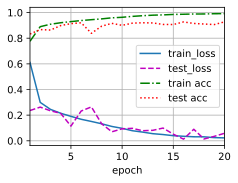

In [14]:
train_minset_18()